# 🐧 This is the first `LangGraph` Agentic AI application. 

### 🚶‍➡️Here are the following steps.
1. Define the state class
2. Start the Graph bulider
3. Define the node
4. Define the edges
5. Compile the graph

- `STATE` :  represents current snapshot of the application
    - State is immutable
- `NODE`  :  Python code that do the work. Take state as input and produce new state
- `EDGE`  :  Edge choose what to do next


<table>
  <tr>
    <td width="20%">
      <img src="../images/BasicAgent.png" alt="Description Image" style="width:100%;">
    </td>
    <td width="80%" style="vertical-align: top;">
      <p>This is the basic design of the of the Graph without memory</p>
    </td>
  </tr>
</table>




In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from pydantic import BaseModel
import random
import os
from langgraph.prebuilt import ToolNode, tools_condition


c:\PRANAB\CODE\OpenAI\AgenticAI\AgenticAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

Here is the command that is used to run ollama 3.2
 - Open PowerShell
 - Run the command - `ollama run llama3.2`

In [3]:
# We can choose any model to perform this operation. I am choosing a open model here ollama. Both the code are present over here.

#Initialize Ollama instead of ChatOpenAI
# llm = ChatOllama(
#     model="llama3.2",
#     temperature=0,
#     # base_url="http://localhost:11434"  # Default value, usually not needed
# )

# Open AI Code. I commenting this code for now to use Ollama
MODEL_NAME = os.getenv(key="MODEL_NAME")
llm = ChatOpenAI(model=MODEL_NAME)

#### 🔨 Setting up the tool section

In [4]:
# Search(SerpAPI) API set up details is present in the README file
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.tools import Tool


serper_client = SerpAPIWrapper()
# serach.run("What is the capital of India?")

tool_google_search = Tool(
    name="google_search",
    func=serper_client.run,
    description="Useful for when you need to answer questions about current events, "
                "people, or companies. Always use this tool if the user asks for "
                "up-to-date information."
)

# Where is the sample code for calling the tool
# tool_google_search.invoke("What is the capital of India?")



# Setting another tool for sending the output

def send_information(text: str)-> str:
    """Send the notification via different channel as needed."""
    print(text)
    return "Information has been sent"

tool_send = Tool(
    name="send_information",
    func=send_information,
    description="Useful tool to send notification via different channel as needed."
)    

tools = [tool_google_search, tool_send]

### 🪦Setting up SQLite DB for memory

In [5]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "chat_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

🚶‍➡️Step 1: Define the State class
- State can a Pydentic BaseModel or TypedDict

In [6]:
class State(BaseModel):        
    messages: Annotated[list, add_messages]

🚶‍➡️Step 2: Start the Graph Builder with the State Class

In [7]:
graph_builder = StateGraph(State)

🚶‍➡️Step 3: Define the nodes

In [8]:
# create an llm object with tools

llm_with_tools = llm.bind_tools(tools)

def chat_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chat_node)

# create another node to call the tools
graph_builder.add_node("tools", ToolNode(tools=tools))

🚶‍➡️Step 4: Setup the edges
- LangGraph will add a node with any unresolved node. That's I have not mentioned `chatbot` to `END` node

In [9]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge( "tools","chatbot")

🚶‍➡️Step 5: Compile the edges

In [10]:
graph = graph_builder.compile(checkpointer=sql_memory)

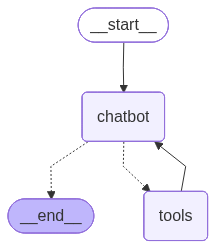

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
config = {"configurable":{"thread_id":1}}
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat).launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
